In [1]:
import requests 

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import numpy as np
import folium
import json

from time import sleep
import os
import csv
from dotenv import load_dotenv
import requests
import json
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



In [2]:
import plotly.io as pio
#pio.renderers.default = 'notebook' # PARA JUPYTER NOTEBOOK
pio.renderers.default = 'iframe' #PARA JUPYTER LAB


In [3]:
#Parámetros para descargar de Airtable nuestro CSV

API_KEY = 'pati6Y8fiw0iWMkUi.e90a0282a58b37405e0876c7527d0ea91694ee79db95070a430764520937f2db'
BASE_ID = 'appUVXd9KqaLweALk'
TABLE_NAME = 'tblgabrDr332V06zz'
HEADERS = {
    'Authorization': f'Bearer {API_KEY}',
    'Content-Type': 'application/json'
}
URL = f'https://api.airtable.com/v0/{BASE_ID}/{TABLE_NAME}'


In [4]:
#Importante abrir el .json con formato UTF-8
world_geo_espanha = 'Data/Municipios_IGN.json'
with open(world_geo_espanha, encoding="utf-8") as json_file:
    json_data_espanha = json.load(json_file)
    

world_geo_madrid = 'Data/madrid-districts.json'
with open(world_geo_madrid, encoding="utf-8") as json_file:
    json_data_madrid = json.load(json_file)

In [106]:
df_galicia = pd.read_csv('datos_galicia_geodata.csv')

In [107]:
df_galicia = df_galicia.drop_duplicates(keep = 'first').reset_index(drop=True)

In [5]:
for elemento in json_data_madrid['features']:
    elemento['properties']['name'] = elemento['properties']['name'].upper()
    if 'SAN BLAS' in elemento['properties']['name']:
        elemento['properties']['name'] = ''+elemento['properties']['name']+'-CANILLEJAS'

## Coloreamos el mapa con el GeoJson

In [ ]:
#Importante usar el json_data con el encoding=UTF-8

world_map = folium.Map(location = [latitud, longitud], zoom_start = 4)

folium.Choropleth(geo_data = json_data).add_to(world_map)

world_map

In [6]:
#Definimos función para descarga de datos de Airtable
def extraer_datos_airtable(api_url, api_key):
    headers = {
        "Authorization": f"Bearer {api_key}"
    }

    response = requests.get(api_url, headers=headers)
    if response.status_code == 200:
        records = response.json().get("records", [])
        data = [record['fields'] for record in records]
        return pd.DataFrame(data)
    else:
        print(f"Error al extraer datos: {response.text}")
        return None

In [7]:
df_madrid = pd.read_csv('datos_madrid_geodata_condistrito.csv')

In [8]:
#df_madrid_dist = pd.read_csv('datos_madrid_geodata_condistrito.csv')

In [9]:
df_madrid = df_madrid.drop('Unnamed: 0',axis=1)

In [10]:
df_madrid.head(2)

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas,precio promedio,...,Muy bueno,Excelente,lat,long,municipio,provincia,codigo postal,direccion completa corregida,distrito,barrio
0,Oam Thong,526.0,3.5,1687.0,NaN,"['Asiática', 'Tailandesa']",NaN,"Calle Navarrete 9, 28050 Madrid España","['45', '46', '116', '199', '120']",NaN,...,199.0,120.0,40.499883,-3.672881,Madrid,Madrid,28050,"C. de Navarrete, 9, 28050 Madrid, Spain",FUENCARRAL-EL PARDO,VALVERDE
1,El Rincon del Venezolano,61.0,4.5,1688.0,"[2, 12]","['Comida rápida', 'Caribeña', 'Latina', 'Venez...",['Opciones veganas'],"Avenida del Doctor Federico Rubio y Gali 40, 2...","['7', '0', '1', '1', '52']",7.0,...,1.0,52.0,40.451315,-3.709298,Madrid,Madrid,28039,"Av. del Doctor Federico Rubio y Gali, 40, 2803...",TETUAN,BELLAS VISTAS


In [11]:
#Limpiamos campo de las puntuaciones desglosadas
mask_no_nan = ~df_madrid['puntuaciones desglosadas'].isna()

def str_list_to_list(str_list):
    lista = str_list.split("'")[1::2]
    lista = [x.strip() for x in lista]
    return lista

df_madrid.loc[mask_no_nan, 'puntuaciones desglosadas'] = df_madrid.loc[mask_no_nan, 'puntuaciones desglosadas'].apply(str_list_to_list)

In [12]:
#Definimos una función que nos devuelva un DataFrame que usaremos para mostrar los promedios de las puntuaciones por cada municipio

def promedio_puntuacion_distrito(data_frame):
    df_puntuaciones = data_frame.groupby('distrito')['puntuaciones desglosadas'].sum().to_frame().reset_index()
    result = []
    for list_punt in df_puntuaciones['puntuaciones desglosadas'].values:
        list_float = [float(punt) for punt in list_punt]
        result.append(np.mean(list_float))
    df_puntuaciones['promedio puntuaciones'] = result
    return df_puntuaciones

In [13]:
#Definimos una función que nos devuelva un DataFrame que usaremos para mostrar los promedios de las puntuaciones por cada municipio

def promedio_puntuacion_municipio(data_frame):
    df_puntuaciones = data_frame.groupby('municipio')['puntuaciones desglosadas'].sum().to_frame().reset_index()
    result = []
    for list_punt in df_puntuaciones['puntuaciones desglosadas'].values:
        list_float = [float(punt) for punt in list_punt]
        result.append(np.mean(list_float))
    df_puntuaciones['promedio puntuaciones'] = result
    return df_puntuaciones

In [14]:
df_distrito_promedio = promedio_puntuacion_distrito(df_madrid)

In [15]:
df_municipios_promedio = promedio_puntuacion_municipio(df_madrid)

In [16]:
df_distrito_promedio

,distrito,puntuaciones desglosadas,promedio puntuaciones
0,ARGANZUELA,"[22, 23, 37, 117, 93, 1, 2, 5, 14, 33, 1, 1, 3...",7.134884
1,BARAJAS,"[0, 0, 1, 4, 9, 1, 1, 7, 15, 8, 0, 4, 3, 5, 6,...",4.514286
2,CARABANCHEL,"[19, 10, 22, 47, 86, 3, 3, 9, 33, 34, 0, 0, 0,...",6.170000
3,CENTRO,"[4, 0, 0, 17, 37, 28, 7, 11, 24, 66, 4, 1, 1, ...",12.945882
4,CHAMARTIN,"[0, 0, 1, 2, 18, 5, 6, 10, 19, 29, 0, 0, 0, 4,...",16.814035
5,CHAMBERI,"[0, 0, 0, 0, 15, 0, 0, 0, 1, 14, 5, 6, 7, 16, ...",10.529630
6,CIUDAD LINEAL,"[2, 2, 1, 20, 31, 11, 10, 11, 22, 13, 3, 5, 16...",9.950000
7,FUENCARRAL-EL PARDO,"[45, 46, 116, 199, 120, 7, 5, 12, 24, 55, 0, 0...",11.776923
8,HORTALEZA,"[18, 10, 37, 96, 62, 5, 7, 14, 21, 50, 0, 0, 0...",8.626667
9,LATINA,"[3, 2, 3, 11, 40, 27, 11, 20, 21, 84, 6, 2, 2,...",14.184615


In [112]:
#Mostramos los datos por municipio para que machee con nuestro GeoJson y el promedio de puntuaciones para el json de Galicia

world_map = folium.Map(location = [df_galicia['lat'].values[0], df_galicia['long'].values[0]], zoom_start = 7)

folium.Choropleth(geo_data = json_data_espanha,
                  data     = df_galicia.groupby('municipio')['nombre'].count(),
                  bins = 250,
                  columns  = ["municipio"],
                  key_on   = "feature.properties.NAMEUNIT").add_to(world_map)

world_map

ValueError: key_on `'properties.name'` not found in GeoJSON.

In [18]:
#Mostramos los datos por municipio para que machee con nuestro GeoJson y el promedio de puntuaciones para el json de Madrid

world_map = folium.Map(location = [df_madrid['lat'].values[0], df_madrid['long'].values[0]], zoom_start = 7)

folium.Choropleth(geo_data = json_data_madrid,
                  data     = df_distrito_promedio,
                  bins = 250,
                  columns  = ["distrito", "promedio puntuaciones"],
                  key_on   = "feature.properties.name").add_to(world_map)

world_map

#### Podemos observar que de momento el Choropleth solo machea el municipio Madrid ya que estamos tratando un DataFrame con muy pocos datos

## Folium para ver los restaurantes de cada municipio y su información

In [20]:
#Limpiamos las columnas lat y long
df_madrid['lat']=[float(round(lat,2)) for lat in df_madrid['lat'].values]
df_madrid['long']=[float(round(lat,2)) for lat in df_madrid['long'].values]

In [22]:
from folium import plugins

In [23]:
# Inicializa el mapa ubicado en Madrid
sf_map = folium.Map(location = [df_madrid['lat'].values[0], df_madrid['long'].values[0]], zoom_start = 7)

# Inicializamos un MarkerCluster() para los incidentes en el DataFrame
incidents = plugins.MarkerCluster()

for idx, row in df_madrid.iterrows(): 
    
    lat = row['lat']
    lng = row['long']
    label = row['nombre']
    direccion = row['direccion completa corregida']
    
    incidents.add_child(folium.Marker(location = [lat, lng],
                                      icon = folium.Icon(icon = "fa-solid fa-utensils",
                                                         icon_color = "white",
                                                         color = "green",
                                                         prefix = "fa"),
                                      popup    = label,
                                      tootltip = direccion))


# Agrega incidentes al mapa
sf_map.add_child(incidents)

sf_map

In [25]:
df_temporal_promedio = df_madrid.groupby('distrito')['puntuacion sobre 5'].mean().to_frame().reset_index()
df_temporal_promedio['promedio precio'] = df_madrid.groupby('distrito')['precio promedio'].mean().values
df_temporal_promedio['num opiniones'] = df_madrid.groupby('distrito')['precio promedio'].sum().values
df_temporal_promedio['mayor ranking'] = df_madrid.groupby('distrito')['ranking'].min().values

In [26]:
df_temporal_promedio

,distrito,puntuacion sobre 5,promedio precio,num opiniones,mayor ranking
0,ARGANZUELA,4.127907,23.384615,304.0,1717.0
1,BARAJAS,3.857143,21.000000,21.0,3479.0
2,CARABANCHEL,4.300000,17.000000,85.0,1776.0
3,CENTRO,4.176471,16.296296,1760.0,53.0
4,CHAMARTIN,4.131579,19.450000,389.0,1719.0
5,CHAMBERI,4.282407,20.022727,881.0,143.0
6,CIUDAD LINEAL,4.071429,23.100000,231.0,1960.0
7,FUENCARRAL-EL PARDO,4.192308,16.125000,129.0,1687.0
8,HORTALEZA,4.100000,14.000000,42.0,1909.0
9,LATINA,4.192308,9.000000,27.0,1689.0


In [27]:
px.strip(data_frame = df_temporal_promedio,
         x          = "puntuacion sobre 5",
         y          = "promedio precio",
         color      = "distrito")

In [28]:
df_madrid.head(2)

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas,precio promedio,...,Muy bueno,Excelente,lat,long,municipio,provincia,codigo postal,direccion completa corregida,distrito,barrio
0,Oam Thong,526.0,3.5,1687.0,NaN,"['Asiática', 'Tailandesa']",NaN,"Calle Navarrete 9, 28050 Madrid España","[45, 46, 116, 199, 120]",NaN,...,199.0,120.0,40.50,-3.67,Madrid,Madrid,28050,"C. de Navarrete, 9, 28050 Madrid, Spain",FUENCARRAL-EL PARDO,VALVERDE
1,El Rincon del Venezolano,61.0,4.5,1688.0,"[2, 12]","['Comida rápida', 'Caribeña', 'Latina', 'Venez...",['Opciones veganas'],"Avenida del Doctor Federico Rubio y Gali 40, 2...","[7, 0, 1, 1, 52]",7.0,...,1.0,52.0,40.45,-3.71,Madrid,Madrid,28039,"Av. del Doctor Federico Rubio y Gali, 40, 2803...",TETUAN,BELLAS VISTAS


In [29]:
#Hemos sacado una lista de las franquicias más conocidas en España

franquicias_restauracion = [
    "100 Montaditos",
    "Vips",
    "Foster's Hollywood",
    "La Tagliatella",
    "Pans & Company",
    "Taco Bell",
    "KFC",
    "Burger King",
    "McDonald's",
    "Ginos",
    "Foster's Hollywood",
    "Farggi",
    "Rodilla",
    "Panaria",
    "TGB",
    "Goiko Grill"
]

In [129]:
#Pintamos la ubicación de franquicias en un mapa para ver su ubicación y su nombre en Galicia

franquicias_map = folium.Map(location = [df_galicia['lat'].values[0], df_galicia['long'].values[0]], zoom_start = 7)
# Inicializamos un MarkerCluster() para los incidentes en el DataFrame
incidents = plugins.MarkerCluster()

for idx, row in df_galicia[df_galicia['nombre'].isin(franquicias_restauracion)].iterrows(): 
    
    lat = row['lat']
    lng = row['long']
    label = row['nombre']
    direccion = row['direccion completa corregida']
    
    incidents.add_child(folium.Marker(location = [lat, lng],
                                      icon = folium.Icon(icon = "fa-solid fa-utensils",
                                                         icon_color = "white",
                                                         color = "green",
                                                         prefix = "fa"),
                                      popup    = label,
                                      tootltip = direccion))


# Agrega incidentes al mapa
franquicias_map.add_child(incidents)

franquicias_map

In [130]:
#Pintamos la ubicación de franquicias en un mapa para ver su ubicación y su nombre en Madrid

franquicias_map = folium.Map(location = [df_madrid['lat'].values[0], df_madrid['long'].values[0]], zoom_start = 7)
# Inicializamos un MarkerCluster() para los incidentes en el DataFrame
incidents = plugins.MarkerCluster()

for idx, row in df_madrid[df_madrid['nombre'].isin(franquicias_restauracion)].iterrows(): 
    
    lat = row['lat']
    lng = row['long']
    label = row['nombre']
    direccion = row['direccion completa corregida']
    
    incidents.add_child(folium.Marker(location = [lat, lng],
                                      icon = folium.Icon(icon = "fa-solid fa-utensils",
                                                         icon_color = "white",
                                                         color = "green",
                                                         prefix = "fa"),
                                      popup    = label,
                                      tootltip = direccion))


# Agrega incidentes al mapa
franquicias_map.add_child(incidents)

franquicias_map

In [114]:
#Conteo de las franquicias con diferente nombre
df_madrid[df_madrid['nombre'].isin(franquicias_restauracion)].groupby('nombre')['nombre'].count()

nombre
Burger King    1
McDonald's     1
Rodilla        2
Taco Bell      1
Name: nombre, dtype: int64

In [32]:
franquicias = df_madrid[df_madrid['nombre'].isin(franquicias_restauracion)]['nombre'].unique()

In [34]:
df_madrid[df_madrid['nombre']==franquicias[0]]['lat'].values[0]

40.42

In [36]:
from geopy.distance import distance

In [128]:
df_galicia

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas,precio promedio,...,Normal,Muy bueno,Excelente,lat,long,municipio,provincia,codigo postal,direccion completa corregida,datos completos
0,Terreo Cocina Casual,489.0,5.0,NaN,NaN,"['Mediterránea', 'Española', 'Saludable', 'Con...",NaN,"San Andrés, 109, 15003 A Coruña España","['2', '1', '11', '54', '421']",NaN,...,11.0,54.0,421.0,43.369147,-8.403787,A Coruña,A Coruña,15003,"R. San Andrés, 109, 15003 A Coruña, Spain",{'results': [{'address_components': [{'long_na...
1,Deabejas,559.0,4.5,NaN,"[2, 14]","['Española', 'Bar', 'Mediterránea']","['Opciones veganas', 'Opciones sin gluten']","Calle de los Olmos 2, 15003 A Coruña España","['6', '10', '17', '69', '457']",8.0,...,17.0,69.0,457.0,43.369887,-8.401654,A Coruña,A Coruña,15003,"R. Olmos, 2, 15003 A Coruña, Spain",{'results': [{'address_components': [{'long_na...
2,El De Alberto,2663.0,4.5,NaN,NaN,"['Mediterránea', 'Europea', 'Española', 'Salud...",NaN,"Calle Comandante Fontanes, 1, 15003 A Coruña E...","['15', '27', '100', '523', '1.998']",NaN,...,100.0,523.0,1998.0,43.369803,-8.404916,A Coruña,A Coruña,15003,"Rúa Comandante Fontanes, 1, 15003 A Coruña, Spain",{'results': [{'address_components': [{'long_na...
3,Sibuya Urban Sushi Bar A Coruña,712.0,4.5,NaN,"[12, 30]","['Japonesa', 'Sushi', 'Asiática', 'Saludable',...","['Opciones vegetarianas', 'Opciones veganas', ...","San Andrés 21 Plaza de la Galera, 15003 A Coru...","['35', '32', '36', '100', '509']",21.0,...,36.0,100.0,509.0,43.370974,-8.401035,Rúa San Andrés,A Coruña,15003,"R. San Andrés, 21, 1Drch, 15003 A Coruña, Spain",{'results': [{'address_components': [{'long_na...
4,HANGAR 218,417.0,4.5,NaN,"[4, 25]","['Americana', 'Internacional']",['Opciones sin gluten'],"Rua Ponte, 2 Vilarodis, 15141 Arteixo España","['7', '5', '14', '43', '348']",14.0,...,14.0,43.0,348.0,43.316756,-8.481716,Arteixo,A Coruña,15141,"Rúa Ponte, 2, 15141 Arteixo, A Coruña, Spain",{'results': [{'address_components': [{'long_na...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5529,Restaurante Olegario,58.0,3.0,NaN,NaN,"['Europea', 'Española']",NaN,"Estrada de Viñoas 3, 32160, Nogueira de Ramuín...","['9', '9', '12', '16', '12']",NaN,...,12.0,16.0,12.0,42.412000,-7.727031,Estrada de Viñoas,Luintra,32160,"Lugar, Estrada de Viñoas, 3, 32160 Luintra, Ou...",{'results': [{'address_components': [{'long_na...
5530,Taberna Grancas,2.0,5.0,NaN,NaN,"['Caribeña', 'Europea', 'Venezolana', 'Cubana'...",NaN,"Da, Arrabal Ribadela Número 3, 32930 Toén España","['0', '0', '0', '0', '2']",NaN,...,0.0,0.0,2.0,42.316203,-7.954655,Toén,Ourense,32930,"Arrabal Ribadela, 3, 32930 Toén, Ourense, Spain",{'results': [{'address_components': [{'long_na...
5531,Restaurante Hong Kong,16.0,3.5,NaN,NaN,"['China', 'Sushi', 'Asiática']",NaN,"Calle Emilia Pardo Bazán, 46 BAJO, 32004 Ouren...","['2', '1', '1', '8', '4']",NaN,...,1.0,8.0,4.0,42.338364,-7.860429,Ourense,Ourense,32004,"Rúa Emilia Pardo Bazán, 46, 32004 Ourense, Spain",{'results': [{'address_components': [{'long_na...
5532,Telepizza,6.0,4.0,NaN,NaN,['Italiana'],NaN,"Paseo Malecon, 16, 32300 O Barco de Valdeorras...","['0', '0', '1', '4', '1']",NaN,...,1.0,4.0,1.0,42.415167,-6.983695,Plaza José Otero,El Barco de Valdeorras,32300,"Pl. José Otero, Esquina, Malecon, 5, 32300 El ...",{'results': [{'address_components': [{'long_na...


In [126]:
#Visualización de franquicias en Galicia

results = []

incidents = plugins.MarkerCluster()

center = (df_galicia['lat'].values[0],df_galicia['long'].values[0])
m = folium.Map(location=center, zoom_start=10)

for franquicia in franquicias:
    df_temporal = df_madrid[df_galicia['nombre']==franquicia]
    center = (df_temporal['lat'].values[0],df_temporal['long'].values[0])
    radius = 200

    folium.Circle(center, radius=radius, color='red', fill=True, fill_color='red').add_to(m)


    for idx, row in df_temporal.iterrows():

        lat = float(row['lat'])
        lng = float(row['long'])
        label = row['nombre']

        dist = distance(center, (lat, lng)).m

        if  dist <= radius:
            results.append(dist)
        print(results)
        
        
        incidents.add_child(folium.Marker(location = [lat, lng],
                                          icon = folium.Icon(icon = "fa-solid fa-utensils",
                                                             icon_color = "white",
                                                             color = "green",
                                                             prefix = "fa"),
                                          popup    = label))

    m.add_child(incidents)
    
m

C:\Users\danii\AppData\Local\Temp\ipykernel_22064\3254238005.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



IndexError: index 0 is out of bounds for axis 0 with size 0

In [125]:
#Visualización de franquicias en Madrid

results = []

incidents = plugins.MarkerCluster()

center = (df_madrid['lat'].values[0],df_madrid['long'].values[0])
m = folium.Map(location=center, zoom_start=10)

for franquicia in franquicias:
    df_temporal = df_madrid[df_madrid['nombre']==franquicia]
    center = (df_temporal['lat'].values[0],df_temporal['long'].values[0])
    radius = 200

    folium.Circle(center, radius=radius, color='red', fill=True, fill_color='red').add_to(m)


    for idx, row in df_temporal.iterrows():

        lat = float(row['lat'])
        lng = float(row['long'])
        label = row['nombre']

        dist = distance(center, (lat, lng)).m

        if  dist <= radius:
            results.append(dist)
        print(results)
        
        
        incidents.add_child(folium.Marker(location = [lat, lng],
                                          icon = folium.Icon(icon = "fa-solid fa-utensils",
                                                             icon_color = "white",
                                                             color = "green",
                                                             prefix = "fa"),
                                          popup    = label))

    m.add_child(incidents)
    
m

[0.0]
[0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]


In [51]:
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

In [88]:
def distancia_centro_madrid(localizacion):
    localizacion_centro = [40.41831, -3.70275]
    distancia_centro = geodesic((localizacion_centro[0], localizacion_centro[1]), (float(localizacion[0]), float(localizacion[1])))
    return distancia_centro.km

In [90]:
df_madrid['localizacion'] = {i: (df_madrid['lat'].values[i],df_madrid['long'].values[i]) for i in range(len(df_madrid['lat'].values))}

In [91]:
df_madrid['distancia al centro'] = df_madrid['localizacion'].apply(distancia_centro_madrid)

In [92]:
df_madrid.head(1)

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas,precio promedio,...,lat,long,municipio,provincia,codigo postal,direccion completa corregida,distrito,barrio,localizacion,distancia al centro
0,Oam Thong,526.0,3.5,1687.0,NaN,"['Asiática', 'Tailandesa']",NaN,"Calle Navarrete 9, 28050 Madrid España","[45, 46, 116, 199, 120]",NaN,...,40.5,-3.67,Madrid,Madrid,28050,"C. de Navarrete, 9, 28050 Madrid, Spain",FUENCARRAL-EL PARDO,VALVERDE,"(40.5, -3.67)",9.486934


In [104]:
#Precio promedio por distrito dependiendo de la distancia al centro

px.scatter(data_frame  = df_madrid,
           x           = "distancia al centro",
           y    = "precio promedio",
           color = "distrito",
           opacity     = 0.5)

In [115]:
df_madrid.head(1)

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas,precio promedio,...,lat,long,municipio,provincia,codigo postal,direccion completa corregida,distrito,barrio,localizacion,distancia al centro
0,Oam Thong,526.0,3.5,1687.0,NaN,"['Asiática', 'Tailandesa']",NaN,"Calle Navarrete 9, 28050 Madrid España","[45, 46, 116, 199, 120]",NaN,...,40.5,-3.67,Madrid,Madrid,28050,"C. de Navarrete, 9, 28050 Madrid, Spain",FUENCARRAL-EL PARDO,VALVERDE,"(40.5, -3.67)",9.486934


In [124]:
#Precio promedio por distrito

px.box(data_frame = df_madrid,
       x          = "distrito",
       y          = "precio promedio",
       hover_name = "nombre")

In [132]:
#Precio promedio por barrio

px.box(data_frame = df_madrid,
       x          = "barrio",
       y          = "precio promedio",
       hover_name = "nombre")

In [100]:
df_madrid.head(1)

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas,precio promedio,...,lat,long,municipio,provincia,codigo postal,direccion completa corregida,distrito,barrio,localizacion,distancia al centro
0,Oam Thong,526.0,3.5,1687.0,NaN,"['Asiática', 'Tailandesa']",NaN,"Calle Navarrete 9, 28050 Madrid España","[45, 46, 116, 199, 120]",NaN,...,40.5,-3.67,Madrid,Madrid,28050,"C. de Navarrete, 9, 28050 Madrid, Spain",FUENCARRAL-EL PARDO,VALVERDE,"(40.5, -3.67)",9.486934


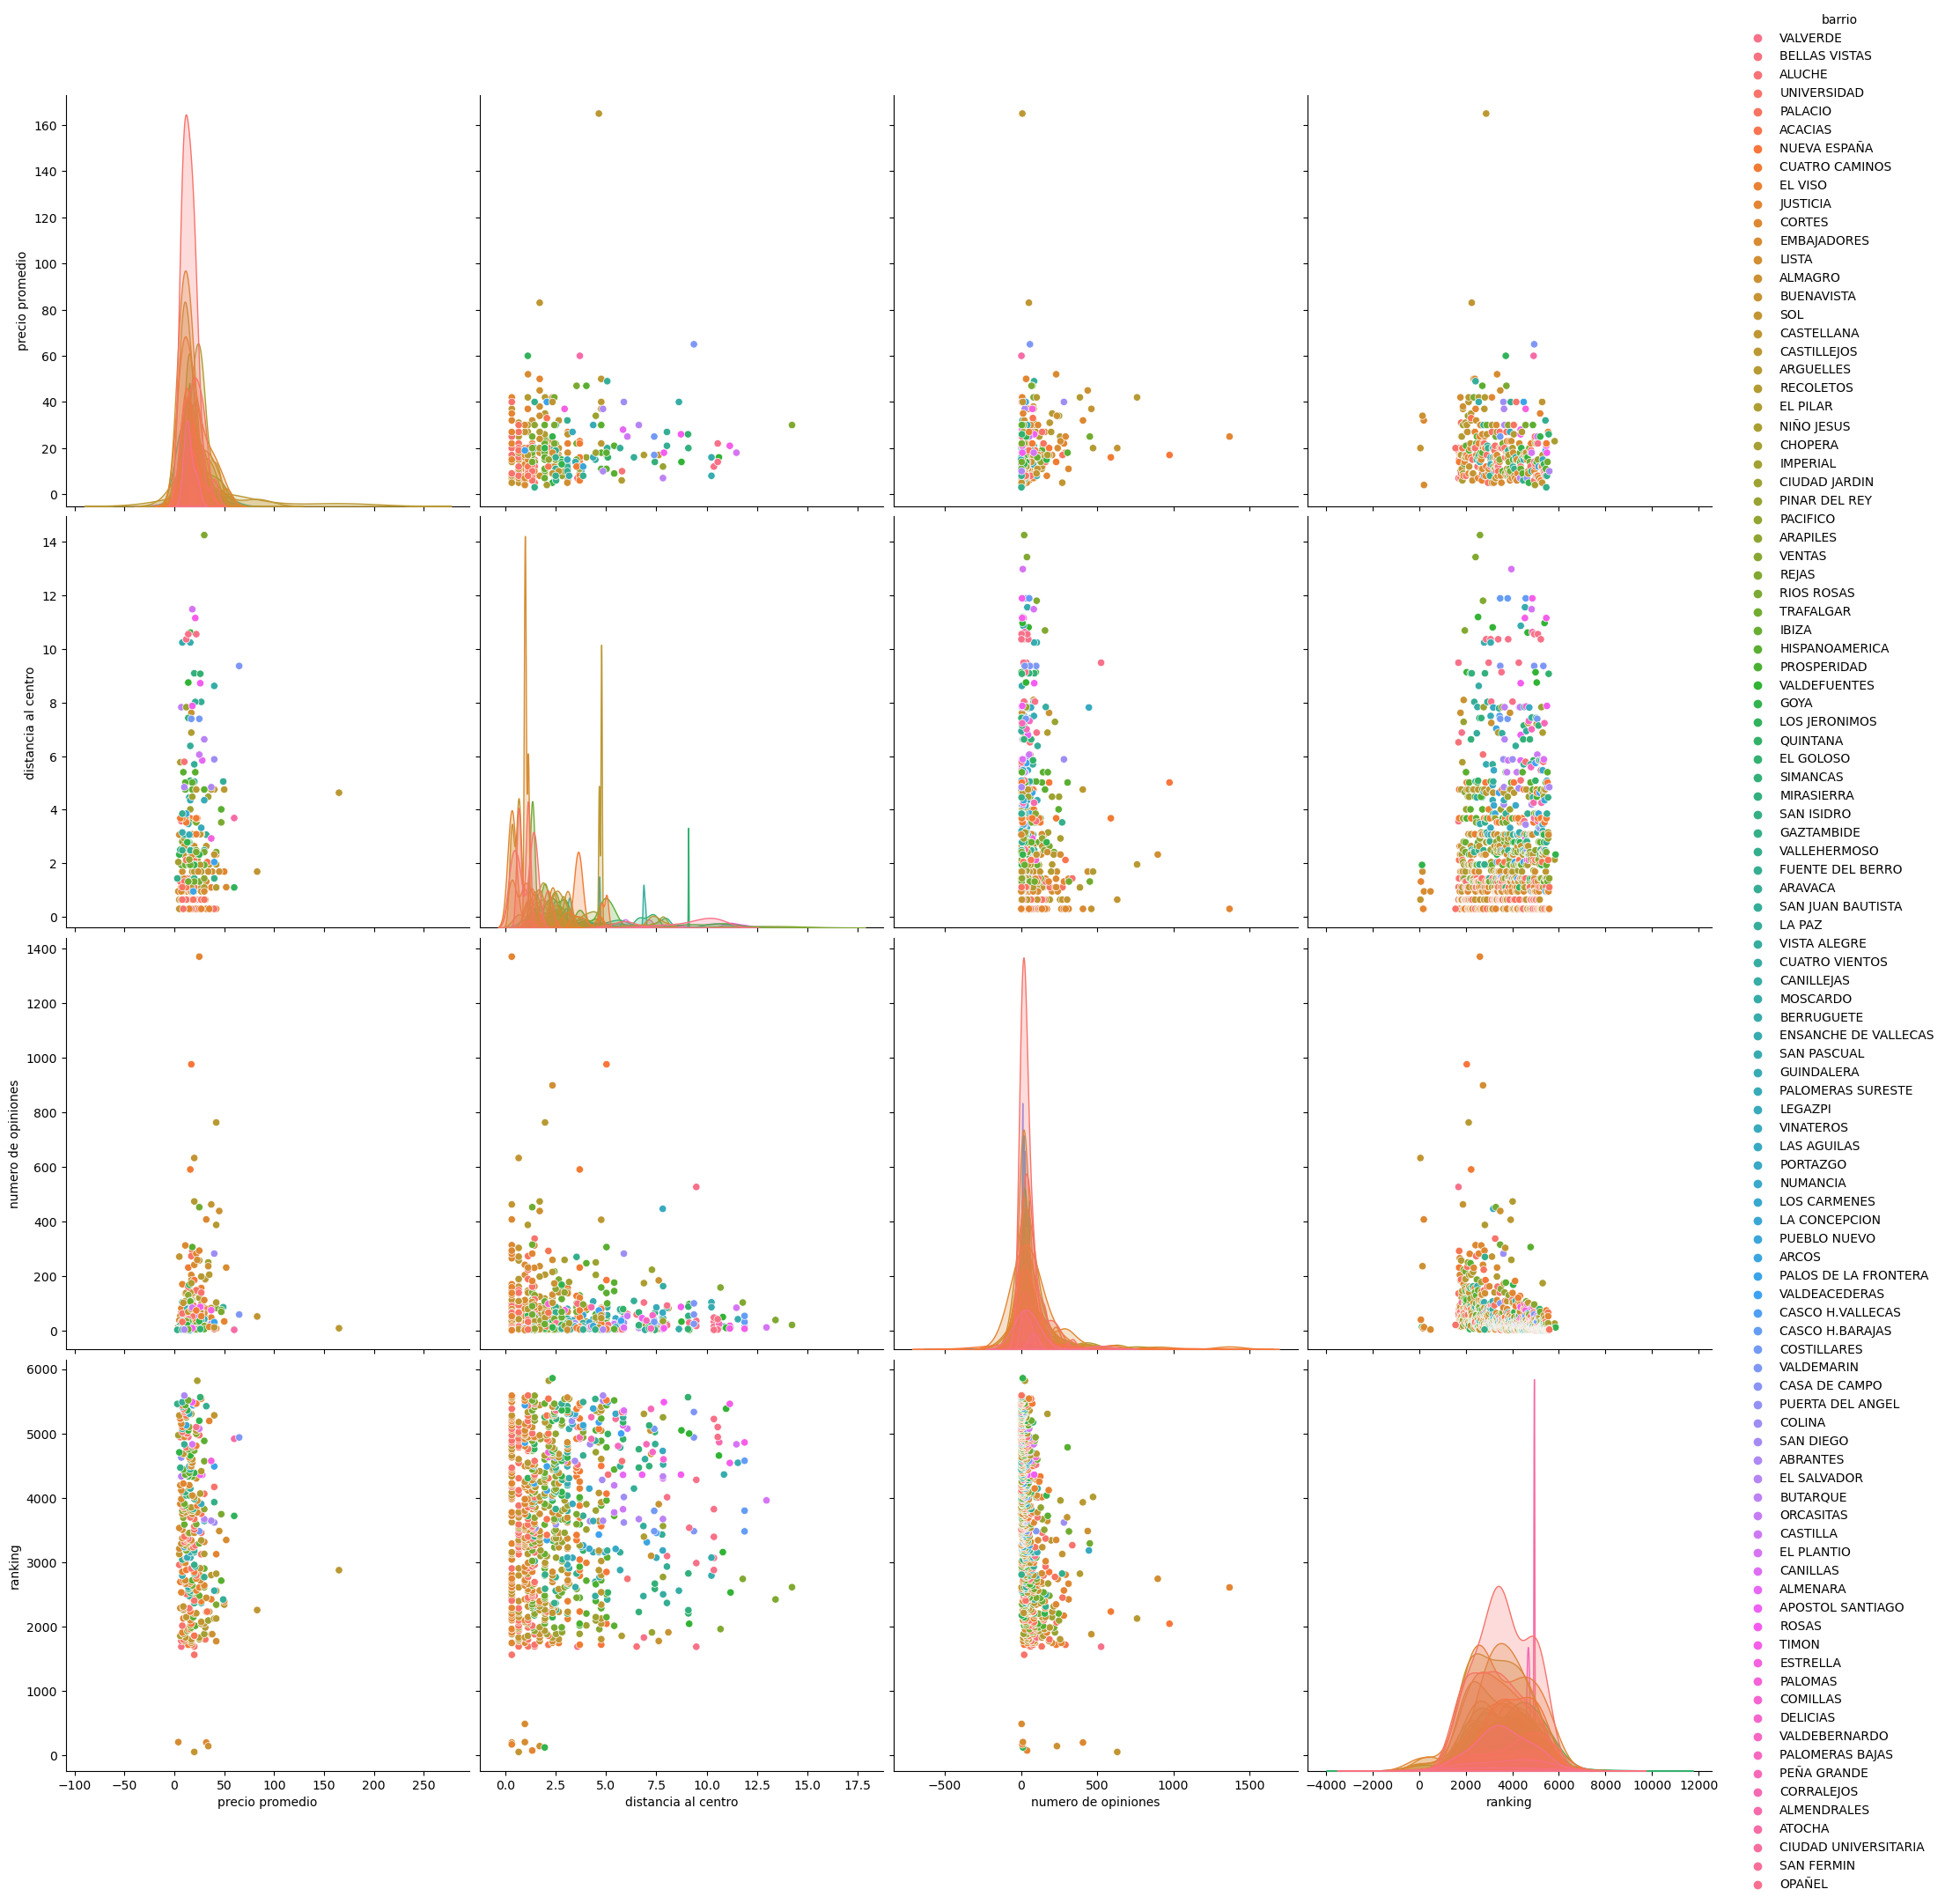

In [133]:
#Comparación de las columnas 'precio promedio', 'distancia al centro', 'numero de opiniones', 'ranking'

sns.pairplot(df_madrid, vars = ["precio promedio", "distancia al centro","numero de opiniones","ranking"], height = 5, hue = "barrio")
plt.show()

In [135]:
df_galicia.head(2)

,nombre,numero de opiniones,puntuacion sobre 5,ranking,precio,tipos de cocina,dietas especiales,ubicaciones,puntuaciones desglosadas,precio promedio,...,Normal,Muy bueno,Excelente,lat,long,municipio,provincia,codigo postal,direccion completa corregida,datos completos
0,Terreo Cocina Casual,489.0,5.0,NaN,NaN,"['Mediterránea', 'Española', 'Saludable', 'Con...",NaN,"San Andrés, 109, 15003 A Coruña España","['2', '1', '11', '54', '421']",NaN,...,11.0,54.0,421.0,43.369147,-8.403787,A Coruña,A Coruña,15003,"R. San Andrés, 109, 15003 A Coruña, Spain",{'results': [{'address_components': [{'long_na...
1,Deabejas,559.0,4.5,NaN,"[2, 14]","['Española', 'Bar', 'Mediterránea']","['Opciones veganas', 'Opciones sin gluten']","Calle de los Olmos 2, 15003 A Coruña España","['6', '10', '17', '69', '457']",8.0,...,17.0,69.0,457.0,43.369887,-8.401654,A Coruña,A Coruña,15003,"R. Olmos, 2, 15003 A Coruña, Spain",{'results': [{'address_components': [{'long_na...


In [140]:
df_galicia['provincia'] = df_galicia['direccion completa corregida'].str[::-1].str.split().str[1].str[::-1]

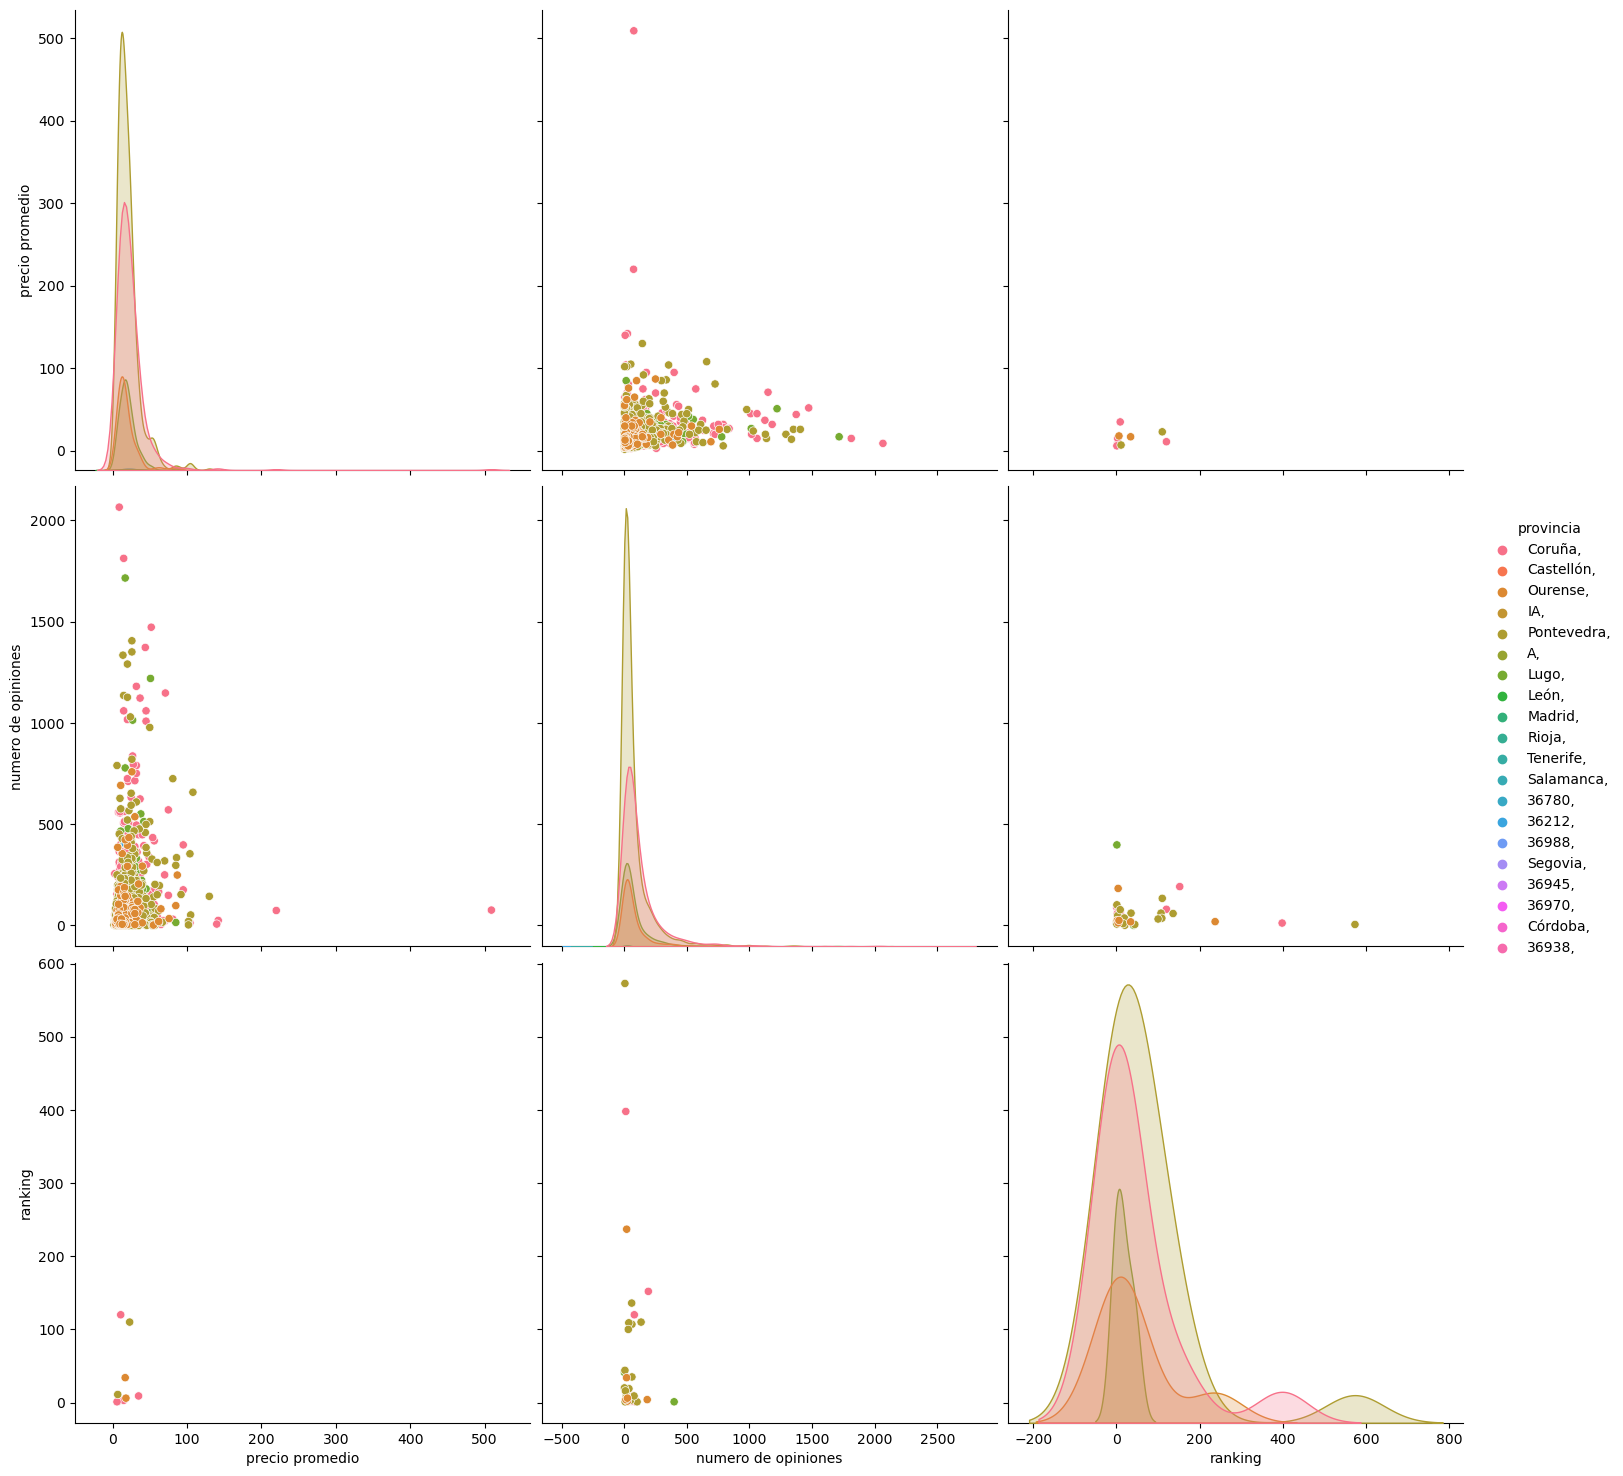

In [141]:
#Comparación de las columnas 'precio promedio', 'numero de opiniones', 'ranking'

sns.pairplot(df_galicia, vars = ["precio promedio", "numero de opiniones","ranking"], height = 5, hue = "provincia")
plt.show()